# Coming from TensorFlow to NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/from-tensorflow.ipynb)

NengoDL combines two frameworks: Nengo and TensorFlow.  This tutorial is designed for
people who are familiar with TensorFlow and looking to learn more about neuromorphic
modelling with NengoDL.  For the other approach, users familiar with Nengo looking to
learn how to use NengoDL, check out [this
tutorial](https://www.nengo.ai/nengo-dl/examples/from-nengo.html).

If you are familiar with Keras you may also be interested in
[KerasSpiking](https://www.nengo.ai/keras-spiking/), a companion project to NengoDL
that has a more minimal feature set, but integrates even more transparently with the
Keras API. See [this page](https://www.nengo.ai/keras-spiking/nengo-dl-comparison.html)
for a more detailed comparison between the two projects.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import nengo
from nengo.utils.matplotlib import rasterplot
import numpy as np
import tensorflow as tf

import nengo_dl


warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

## What is Nengo

We'll start with the very basics, where you might be wondering what Nengo is and why you
would want to use it.  Nengo is a tool for constructing and simulating neural networks.
That is, to some extent, the same purpose as TensorFlow (and its higher level API,
Keras).  For example, here is how we might build a simple two layer auto-encoder network
in TensorFlow:

In [2]:
n_in = 784
n_hidden = 64
minibatch_size = 50

# input
tf_a = tf.keras.Input(shape=(n_in,))

# first layer
tf_b = tf.keras.layers.Dense(
    n_hidden, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_a)

# second layer
tf_c = tf.keras.layers.Dense(
    n_in, activation=tf.nn.relu, kernel_initializer=tf.initializers.glorot_uniform()
)(tf_b)

And here is how we would build the same network architecture in Nengo:

In [3]:
with nengo.Network() as auto_net:
    # input
    nengo_a = nengo.Node(np.zeros(n_in))

    # first layer
    nengo_b = nengo.Ensemble(n_hidden, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(nengo_a, nengo_b.neurons, transform=nengo_dl.dists.Glorot())

    # second layer
    nengo_c = nengo.Ensemble(n_in, 1, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(
        nengo_b.neurons, nengo_c.neurons, transform=nengo_dl.dists.Glorot()
    )

    # probes are used to collect data from the network
    p_c = nengo.Probe(nengo_c.neurons)

One difference you'll note is that with Nengo we separate the creation of the layers and
the creation of the connections between layers.  This is because the connection
structure in Nengo networks often has a lot more state and general complexity than in
typical deep learning networks, so it is helpful to be able to control it independently
(we'll see examples of this later).

Another new object you may notice is the `nengo.Probe`.  This is used to collect data
from the simulation; by adding a probe to `nengo_c.neurons`, we are indicating that we
want to collect the activities of those neurons when the simulation is running.  You can
think of this like the `outputs` arguments in a Keras Model.

We will not go into a lot of detail on Nengo here; there is much more functionality
available, but we will focus on the features most familiar or relevant to those coming
from a TensorFlow background.  For a more in-depth introduction to Nengo, check out the
Nengo-specific [documentation](https://www.nengo.ai/nengo/) and
[examples](https://www.nengo.ai/nengo/examples.html).

## Simulating a network

To simulate a Keras network we create a `Model` and call `model.predict`:

In [4]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
out = model.predict(np.ones((minibatch_size, n_in)))
print(out.shape)

(50, 784)


Again, accomplishing the same thing in Nengo bears many similarities.  We create a
`Simulator` and call `sim.predict`:

In [5]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 1, n_in)))
    print(out[p_c].shape)

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############  Constructing graph: build stage (20%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

(50, 1, 784)


One difference you may note is the extra dimension with size 1 in the shape of the Nengo
inputs and outputs.  This represents the time dimension; in this example we're only
running for a
single timestep, which is why it has size 1, but this could be used to provide different
input values on each simulation timestep.

This highlights a key difference between Nengo and TensorFlow.  Nengo simulations are
fundamentally temporal in nature; unlike TensorFlow where the graph simply represents an
abstract set of computations, in Nengo we (almost) always think of the graph as
representing a stateful neural simulation, where values are accumulated, updated, and
communicated over time.  This is not to say there is no overlap (we can create
TensorFlow simulations that execute over time, and we can create Nengo simulations
without temporal dynamics), but this is a different way of thinking about computations
that influences how we construct and simulate networks in Nengo.

More details on the NengoDL Simulator can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## Spiking networks

Although Nengo can be used to create TensorFlow-style networks, it has been primarily
designed for a different style of modelling: "neuromorphic" networks.  Neuromorphic
networks include features drawn from biological neural networks, in an effort to
understand or recreate the functionality of biological brains.  Note that these models
fall on a spectrum with standard artificial neural networks, with different approaches
incorporating different biological features.  But in general the structure and
parameterization of these networks often differs significantly from standard deep
network architectures.

We touched on this above in the discussion of temporality, which is one common feature
of neuromorphic networks.  Another common characteristic is the use of more complicated
neuron models, in particular spiking neurons.  In contrast to "rate" neurons (like
`relu`) that output a continuous value, spiking neurons communicate via discrete bursts
of output called spikes.

We can visualize this difference with a simple 1-layer network. In this example we'll
use `sim.run_steps` to run the simulation, rather than `sim.predict`.  `sim.run_steps`
(or `sim.run`) is a standard Nengo Simulator execution function (as opposed to
`sim.predict`, which is specific to NengoDL).  We could use either one, but you will
probably see `sim.run` in Nengo code, so we introduce it here.  The main difference in
this case is that results will be stored in the `sim.data` dictionary, as opposed to
being returned directly from `sim.predict`.

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

| #                           Simulating                              | 0:00:00

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

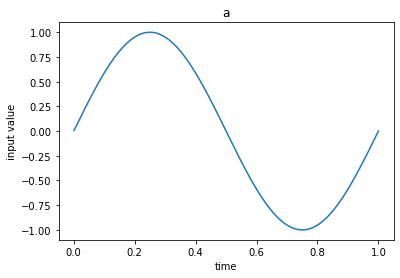

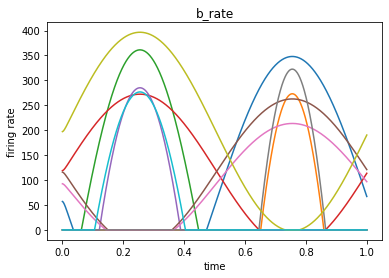

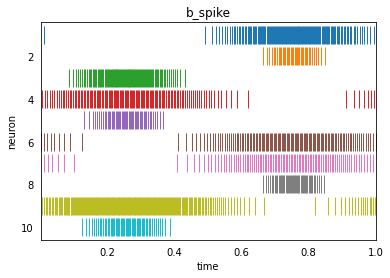

In [6]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))

    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)

    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(10, 1, neuron_type=nengo.SpikingRectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)

    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)

with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input
    # data will be automatically generated based on the sine function
    # in the Node definition.
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")

plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike")
plt.show()

Each neuron responds to the input signal differently due to the random parameterization
in the network (e.g. connection weights and biases).  We have matched the
parameterization in the rate and spiking ensembles so that it is easier to see the
parallels.

Note that the same information is being represented in the two ensembles.  For example,
when the second neuron (orange) is outputting a high continuous value (in the second
graph), the corresponding spiking neuron is outputting more discrete spikes (orange
lines in the third graph).

We can see the parallels more clearly if we introduce another Nengo feature, synaptic
filters.  This is inspired by a biological feature where discrete spikes induce a
continuous electrical waveform in the receiving neuron, at the synapse (the point where
the two neurons connect).  But computationally we can think of this simply as applying a
filter to the spiking signal.

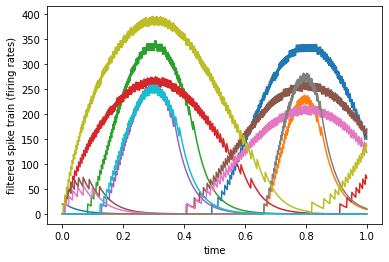

In [7]:
# nengo uses a linear lowpass filter by default
filt = nengo.Lowpass(tau=0.05)

# apply filter to ensemble output spikes
filtered_spikes = filt.filt(sim.data[p_spike])

plt.figure()
plt.plot(sim.trange(), filtered_spikes)
plt.xlabel("time")
plt.ylabel("filtered spike train (firing rates)")
plt.show()

We can see how the spike trains, when viewed through a synaptic filter, approximate the
continuous rate values in the second graph above.

In this example we have computed the filtered signal manually for demonstration
purposes, but in a typical Nengo model these synaptic filters are applied throughout the
model, on the `Connection` objects.  For example, the above filtering would be
equivalent to `nengo.Connection(b_spike.neurons, x, synapse=0.05)` (from the perspective
of a hypothetical downstream object `x`).

This is a helpful duality to keep in mind when coming to neuromorphic modelling and
Nengo from a standard deep network background.  Although spiking neurons seem like a
radically different paradigm, they can compute and communicate the same information as
their rate counterparts.  But note that this only makes sense when we think of the
network temporally (neurons spiking and being filtered over time).

There are many other neuron types built into Nengo (see [the
documentation](https://www.nengo.ai/nengo/frontend-api.html#neuron-types) for a complete
list).  These neuron models have various different behaviours, and managing their
parameterization and simulation is an important part of Nengo's design.

## Inserting TensorFlow code

The goal of NengoDL is not to replace TensorFlow or Nengo, but to allow them to smoothly
work together.  Thus one important feature is the ability to write TensorFlow code
directly, and insert it into a Nengo network.  This allows us to use whichever framework
is best suited for different parts of a model.

This functionality is accessed through the `nengo_dl.TensorNode` class.  This allows us
to wrap TensorFlow code in a Nengo object, so that it can easily communicate with the
rest of a Nengo model.  The TensorFlow code is written in a function that takes
`tf.Tensors` as input, applies the desired manipulations through TensorFlow operations,
and returns a `tf.Tensor`.  We then pass that function to the TensorNode.

For simple cases we can use `nengo_dl.Layer`.  This is a simplified interface for
constructing `TensorNodes` that mimics the Keras functional API.  For example, suppose
we want to apply batch normalization to the output of one of the Nengo ensembles.  There
is no built-in way to do batch normalization in Nengo, so we can instead turn to
TensorFlow for this part of the model.

In [8]:
with net:
    batch_norm = nengo_dl.Layer(tf.keras.layers.BatchNormalization(momentum=0.9))(
        b_rate.neurons
    )
    p_batch_norm = nengo.Probe(batch_norm)

This is essentially equivalent to the Keras layer `tf.keras.layers.BatchNormalization`,
except it works with Nengo objects.  For example, `b_rate` is a `nengo.Ensemble` in this
case, and we can add Probes or Connections to `batch_norm` in the same way as any other
Nengo object.

Using `nengo_dl.Layer` is simply a shortcut for creating a `TensorNode` and
`Connection`; the above is equivalent to

In [9]:
with net:
    batch_norm = nengo_dl.TensorNode(
        tf.keras.layers.BatchNormalization(momentum=0.9),
        shape_in=(10,),
        pass_time=False,
    )
    nengo.Connection(b_rate.neurons, batch_norm, synapse=None)
    p_batch_norm = nengo.Probe(batch_norm)

In general, we can use any function (a built in TensorFlow function or one we write
ourselves) in a TensorNode.  It can accept two parameters, `t` and `x`, where `t` is the
current simulation time and `x` is the value of any Connections incoming to the
TensorNode.  We can use `pass_time=False` if we don't need the time input. `x` will have
shape `(minibatch_size,) + shape_in`, where `shape_in` is the parameter passed to the
`TensorNode` (or inferred from the input object in the case of `nengo_dl.Layer`).  The
`TensorNode`/`Layer` function should return a `tf.Tensor` with shape `(minibatch_size,)
+ shape_out`, where `shape_out` is the output dimensionality of the node (dependent on
the manipulations applied to the inputs `x`).  We could explicitly specify
`shape_out=(10,)` in the above example, or if we don't specify the output shape it will
be determined automatically by calling the node function with placeholder inputs.

Here is a simple network to illustrate a TensorNode's input and output:

In [10]:
with nengo.Network() as net:
    # node to provide an input value for the TensorNode
    a = nengo.Node([0.5, -0.1])

    # a TensorNode function to illustrate i/o
    def tensor_func(t, x):
        # print out the value of inputs t and x
        print_t = tf.print("t:", t)
        with tf.control_dependencies([print_t]):
            print_x = tf.print("x:", x)

        # output t + x
        with tf.control_dependencies([print_x]):
            return tf.add(t, x)

    # create the TensorNode
    b = nengo_dl.TensorNode(tensor_func, shape_in=(2,), shape_out=(2,))
    nengo.Connection(a, b, synapse=None)

    p = nengo.Probe(b)

with nengo_dl.Simulator(net) as sim:
    print("TensorNode input:")
    data = sim.predict(n_steps=10)
    print("TensorNode output:")
    print(data[p])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

TensorNode input:
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

t: 0.001


x: [[0.5 -0.1]]


t: 0.002


x: [[0.5 -0.1]]


t: 0.003


x: [[0.5 -0.1]]


t: 0.004


x: [[0.5 -0.1]]


t: 0.00500000035


x: [[0.5 -0.1]]


t: 0.006


x: [[0.5 -0.1]]


t: 0.007


x: [[0.5 -0.1]]


t: 0.008


x: [[0.5 -0.1]]


t: 0.00900000054


x: [[0.5 -0.1]]


t: 0.0100000007


x: [[0.5 -0.1]]


TensorNode output:
[[[ 0.501 -0.099]
  [ 0.502 -0.098]
  [ 0.503 -0.097]
  [ 0.504 -0.096]
  [ 0.505 -0.095]
  [ 0.506 -0.094]
  [ 0.507 -0.093]
  [ 0.508 -0.092]
  [ 0.509 -0.091]
  [ 0.51  -0.09 ]]]


We can see, as we expect, that the input tensor `t` is reflecting the current simulation
time over the 10 timesteps we executed, and `x` contains the value of the input Node
that we connected to the TensorNode.  And we can see in the probe data that the
TensorNode is outputting the operation we defined in TensorFlow (`tf.add(t, x)`).

We can define more complicated TensorNodes by implementing a custom Keras Layer.  This
can be useful, for example, if the TensorNode requires internal parameters (which should
be created in the Keras Layer's `build` function).

Here is a simple TensorNode that illustrates the usage of a custom Layer:

In [11]:
with nengo.Network() as net:

    class MyLayer(tf.keras.layers.Layer):
        def build(self, input_shapes):
            self.w = self.add_weight(shape=(1, 1))

        def call(self, inputs):
            return inputs * self.w

    a = nengo_dl.TensorNode(MyLayer(), shape_in=(1,), pass_time=False)

More details on TensorNode usage can be found in [the user
guide](https://www.nengo.ai/nengo-dl/tensor-node.html).

## Deep learning parameter optimization

NengoDL allows model parameters to be optimized via TensorFlow optimization algorithms,
through the `Simulator.fit` function.  Returning to the autoencoder examples from the
beginning of this tutorial, we'll optimize those networks to encode MNIST digits.

In [12]:
# download MNIST dataset
(train_data, _), (test_data, _) = tf.keras.datasets.mnist.load_data()
# flatten images
train_data = train_data.reshape((train_data.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))

n_epochs = 2

In TensorFlow the training would be done something like:

Epoch 1/2


   1/1875 [..............................] - ETA: 0s - loss: 6576.0835

  36/1875 [..............................] - ETA: 2s - loss: 4192.5752

  71/1875 [>.............................] - ETA: 2s - loss: 3543.7561

 106/1875 [>.............................] - ETA: 2s - loss: 3159.4224

 142/1875 [=>............................] - ETA: 2s - loss: 2888.0457

 178/1875 [=>............................] - ETA: 2s - loss: 2684.5916

 214/1875 [==>...........................] - ETA: 2s - loss: 2531.2888

 249/1875 [==>...........................] - ETA: 2s - loss: 2417.8660

 284/1875 [===>..........................] - ETA: 2s - loss: 2321.1370

 320/1875 [====>.........................] - ETA: 2s - loss: 2232.9746

 355/1875 [====>.........................] - ETA: 2s - loss: 2159.9692

 391/1875 [=====>........................] - ETA: 2s - loss: 2096.0122

 427/1875 [=====>........................] - ETA: 2s - loss: 2039.2892

 461/1875 [======>.......................] - ETA: 2s - loss: 1990.5618

 496/1875 [======>.......................] - ETA: 1s - loss: 1945.4978

 532/1875 [=======>......................] - ETA: 1s - loss: 1905.5389

 567/1875 [========>.....................] - ETA: 1s - loss: 1869.0267

 602/1875 [========>.....................] - ETA: 1s - loss: 1835.4386

 638/1875 [=========>....................] - ETA: 1s - loss: 1804.1471

 672/1875 [=========>....................] - ETA: 1s - loss: 1776.9908

 707/1875 [==========>...................] - ETA: 1s - loss: 1751.0852

 742/1875 [==========>...................] - ETA: 1s - loss: 1723.5941

 777/1875 [===========>..................] - ETA: 1s - loss: 1699.1033

 813/1875 [============>.................] - ETA: 1s - loss: 1675.3009

 849/1875 [============>.................] - ETA: 1s - loss: 1654.8241

 885/1875 [=============>................] - ETA: 1s - loss: 1635.2386

 921/1875 [=============>................] - ETA: 1s - loss: 1616.5021

 957/1875 [==============>...............] - ETA: 1s - loss: 1599.1855

 992/1875 [==============>...............] - ETA: 1s - loss: 1582.5533

1028/1875 [===============>..............] - ETA: 1s - loss: 1566.9166

1063/1875 [================>.............] - ETA: 1s - loss: 1552.4471

1098/1875 [================>.............] - ETA: 1s - loss: 1539.5754

1133/1875 [=================>............] - ETA: 1s - loss: 1526.2872

1168/1875 [=================>............] - ETA: 1s - loss: 1512.7045

1203/1875 [==================>...........] - ETA: 0s - loss: 1501.2744

1238/1875 [==================>...........] - ETA: 0s - loss: 1490.3706

1274/1875 [===================>..........] - ETA: 0s - loss: 1479.3545

1310/1875 [===================>..........] - ETA: 0s - loss: 1468.0876

1346/1875 [====================>.........] - ETA: 0s - loss: 1458.0549

1381/1875 [=====================>........] - ETA: 0s - loss: 1448.1431

1416/1875 [=====================>........] - ETA: 0s - loss: 1439.0240

1450/1875 [======================>.......] - ETA: 0s - loss: 1430.0808

1486/1875 [======================>.......] - ETA: 0s - loss: 1419.8442

1521/1875 [=======================>......] - ETA: 0s - loss: 1412.0521

1557/1875 [=======================>......] - ETA: 0s - loss: 1403.6804

1593/1875 [========================>.....] - ETA: 0s - loss: 1395.4857

1629/1875 [=========================>....] - ETA: 0s - loss: 1387.9589

1664/1875 [=========================>....] - ETA: 0s - loss: 1380.4524

1699/1875 [==========================>...] - ETA: 0s - loss: 1373.2828

1735/1875 [==========================>...] - ETA: 0s - loss: 1366.5254

1770/1875 [===========================>..] - ETA: 0s - loss: 1360.2542

1805/1875 [===========================>..] - ETA: 0s - loss: 1353.5980

1840/1875 [============================>.] - ETA: 0s - loss: 1347.8665

1875/1875 [==============================] - ETA: 0s - loss: 1342.2590

1875/1875 [==============================] - 3s 1ms/step - loss: 1342.2590


Epoch 2/2
   1/1875 [..............................] - ETA: 0s - loss: 1062.9559

  35/1875 [..............................] - ETA: 2s - loss: 1036.7876

  70/1875 [>.............................] - ETA: 2s - loss: 1027.9994

 106/1875 [>.............................] - ETA: 2s - loss: 1031.0129

 142/1875 [=>............................] - ETA: 2s - loss: 1029.9724

 177/1875 [=>............................] - ETA: 2s - loss: 1025.0090

 213/1875 [==>...........................] - ETA: 2s - loss: 1024.5718

 248/1875 [==>...........................] - ETA: 2s - loss: 1023.7733

 281/1875 [===>..........................] - ETA: 2s - loss: 1022.3524

 317/1875 [====>.........................] - ETA: 2s - loss: 1018.6564

 351/1875 [====>.........................] - ETA: 2s - loss: 1017.1721

 387/1875 [=====>........................] - ETA: 2s - loss: 1015.0120

 423/1875 [=====>........................] - ETA: 2s - loss: 1015.2795

 458/1875 [======>.......................] - ETA: 2s - loss: 1015.9111

 494/1875 [======>.......................] - ETA: 1s - loss: 1014.1346

 529/1875 [=======>......................] - ETA: 1s - loss: 1013.5107

 565/1875 [========>.....................] - ETA: 1s - loss: 1013.4137

 600/1875 [========>.....................] - ETA: 1s - loss: 1013.0749

 629/1875 [=========>....................] - ETA: 1s - loss: 1012.1248

 664/1875 [=========>....................] - ETA: 1s - loss: 1010.1263

 684/1875 [=========>....................] - ETA: 1s - loss: 1010.5278

 719/1875 [==========>...................] - ETA: 1s - loss: 1009.9432

 754/1875 [===========>..................] - ETA: 1s - loss: 1008.9437

 789/1875 [===========>..................] - ETA: 1s - loss: 1008.9269

 825/1875 [============>.................] - ETA: 1s - loss: 1009.0649

 861/1875 [============>.................] - ETA: 1s - loss: 1008.3600

 897/1875 [=============>................] - ETA: 1s - loss: 1007.7145

 932/1875 [=============>................] - ETA: 1s - loss: 1007.9727

 967/1875 [==============>...............] - ETA: 1s - loss: 1007.9492

1002/1875 [===============>..............] - ETA: 1s - loss: 1007.0350

1038/1875 [===============>..............] - ETA: 1s - loss: 1005.5959

1074/1875 [================>.............] - ETA: 1s - loss: 1004.9669

1109/1875 [================>.............] - ETA: 1s - loss: 1004.6738

1144/1875 [=================>............] - ETA: 1s - loss: 1004.1895

1178/1875 [=================>............] - ETA: 1s - loss: 1004.2733

1214/1875 [==================>...........] - ETA: 0s - loss: 1003.9222

1250/1875 [===================>..........] - ETA: 0s - loss: 1002.7250

1285/1875 [===================>..........] - ETA: 0s - loss: 1002.0009

1313/1875 [====================>.........] - ETA: 0s - loss: 1000.9959

1348/1875 [====================>.........] - ETA: 0s - loss: 1000.0005

1379/1875 [=====================>........] - ETA: 0s - loss: 1000.1024

1414/1875 [=====================>........] - ETA: 0s - loss: 1000.1038

1450/1875 [======================>.......] - ETA: 0s - loss: 999.2617 

1485/1875 [======================>.......] - ETA: 0s - loss: 998.1765

1520/1875 [=======================>......] - ETA: 0s - loss: 997.3153

1556/1875 [=======================>......] - ETA: 0s - loss: 996.6971

1592/1875 [========================>.....] - ETA: 0s - loss: 996.1107

1627/1875 [=========================>....] - ETA: 0s - loss: 995.9526

1662/1875 [=========================>....] - ETA: 0s - loss: 995.3783

1697/1875 [==========================>...] - ETA: 0s - loss: 995.0531

1733/1875 [==========================>...] - ETA: 0s - loss: 994.7825

1769/1875 [===========================>..] - ETA: 0s - loss: 994.5398

1796/1875 [===========================>..] - ETA: 0s - loss: 994.5079

1831/1875 [============================>.] - ETA: 0s - loss: 994.5659

1866/1875 [============================>.] - ETA: 0s - loss: 994.3077

1875/1875 [==============================] - 3s 1ms/step - loss: 994.0135


  1/313 [..............................] - ETA: 0s - loss: 869.6505

 49/313 [===>..........................] - ETA: 0s - loss: 881.0276

 98/313 [========>.....................] - ETA: 0s - loss: 880.8162

148/313 [=============>................] - ETA: 0s - loss: 886.2639

198/313 [=================>............] - ETA: 0s - loss: 905.1824

248/313 [======================>.......] - ETA: 0s - loss: 908.9763

298/313 [===========================>..] - ETA: 0s - loss: 928.3171

313/313 [==============================] - 0s 1ms/step - loss: 926.3876


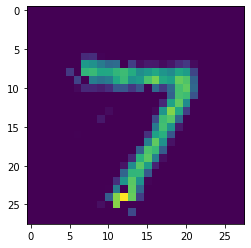

In [13]:
model = tf.keras.Model(inputs=tf_a, outputs=tf_c)
model.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

# run training loop
model.fit(train_data, train_data, epochs=n_epochs)

# evaluate performance on test set
model.evaluate(test_data, test_data)

# display example output
output = model.predict(test_data[[0]])
plt.figure()
plt.imshow(output[0].reshape((28, 28)))
plt.show()

Before running the same training in NengoDL, we'll change the Nengo model parameters to
more closely match the TensorFlow network (we omitted these details in the original
presentation to keep things simple).

In [14]:
# set initial neuron gains to 1 and biases to 0
for ens in auto_net.all_ensembles:
    ens.gain = nengo.dists.Choice([1])
    ens.bias = nengo.dists.Choice([0])

# disable synaptic filtering on all connections
for conn in auto_net.all_connections:
    conn.synapse = None

We also need to modify the data slightly.  As mentioned above, NengoDL simulations are
essentially temporal, so data is described over time (indicating what the inputs/targets
should be on each simulation timestep).  So instead of the data having shape
`(batch_size, n)`, it will have shape `(batch_size, n_steps, n)`.  In this case we'll
just be training for a single timestep, but we still need to add that extra axis with
length 1.

In [15]:
train_data = train_data[:, None, :]
test_data = test_data[:, None, :]

Now we can run the NengoDL equivalent of the above TensorFlow training (note: the
results will not match exactly due to different random initializations):

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

Epoch 1/2


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

   1/1200 [..............................] - ETA: 0s - loss: 6787.0527 - probe_loss: 6787.0527

  17/1200 [..............................] - ETA: 3s - loss: 4667.8286 - probe_loss: 4667.8286

  34/1200 [..............................] - ETA: 3s - loss: 4014.8870 - probe_loss: 4014.8870

  42/1200 [>.............................] - ETA: 4s - loss: 3827.8799 - probe_loss: 3827.8799

  58/1200 [>.............................] - ETA: 4s - loss: 3518.9299 - probe_loss: 3518.9299

  74/1200 [>.............................] - ETA: 3s - loss: 3293.0129 - probe_loss: 3293.0129

  91/1200 [=>............................] - ETA: 3s - loss: 3099.5105 - probe_loss: 3099.5105

 108/1200 [=>............................] - ETA: 3s - loss: 2932.1577 - probe_loss: 2932.1577

 125/1200 [==>...........................] - ETA: 3s - loss: 2803.4333 - probe_loss: 2803.4333

 142/1200 [==>...........................] - ETA: 3s - loss: 2689.6060 - probe_loss: 2689.6060

 159/1200 [==>...........................] - ETA: 3s - loss: 2596.3831 - probe_loss: 2596.3831

 176/1200 [===>..........................] - ETA: 3s - loss: 2510.3284 - probe_loss: 2510.3284

 193/1200 [===>..........................] - ETA: 3s - loss: 2435.7302 - probe_loss: 2435.7302

 210/1200 [====>.........................] - ETA: 3s - loss: 2370.1521 - probe_loss: 2370.1521

 227/1200 [====>.........................] - ETA: 3s - loss: 2311.5430 - probe_loss: 2311.5430

 243/1200 [=====>........................] - ETA: 3s - loss: 2260.2114 - probe_loss: 2260.2114

 260/1200 [=====>........................] - ETA: 2s - loss: 2209.9729 - probe_loss: 2209.9729

 277/1200 [=====>........................] - ETA: 2s - loss: 2163.6458 - probe_loss: 2163.6458

 294/1200 [======>.......................] - ETA: 2s - loss: 2119.7092 - probe_loss: 2119.7092

 311/1200 [======>.......................] - ETA: 2s - loss: 2083.3223 - probe_loss: 2083.3223

 326/1200 [=======>......................] - ETA: 2s - loss: 2050.9993 - probe_loss: 2050.9993

 343/1200 [=======>......................] - ETA: 2s - loss: 2016.3511 - probe_loss: 2016.3511

 360/1200 [========>.....................] - ETA: 2s - loss: 1985.6709 - probe_loss: 1985.6709

 375/1200 [========>.....................] - ETA: 2s - loss: 1959.3563 - probe_loss: 1959.3563

 390/1200 [========>.....................] - ETA: 2s - loss: 1931.6099 - probe_loss: 1931.6099

 407/1200 [=========>....................] - ETA: 2s - loss: 1905.1274 - probe_loss: 1905.1274

 424/1200 [=========>....................] - ETA: 2s - loss: 1879.2428 - probe_loss: 1879.2428

 441/1200 [==========>...................] - ETA: 2s - loss: 1853.4692 - probe_loss: 1853.4692

 458/1200 [==========>...................] - ETA: 2s - loss: 1828.8260 - probe_loss: 1828.8260

 475/1200 [==========>...................] - ETA: 2s - loss: 1806.1742 - probe_loss: 1806.1742

 492/1200 [===========>..................] - ETA: 2s - loss: 1784.5304 - probe_loss: 1784.5304

 508/1200 [===========>..................] - ETA: 2s - loss: 1764.6704 - probe_loss: 1764.6704

 524/1200 [============>.................] - ETA: 2s - loss: 1746.4575 - probe_loss: 1746.4575

 541/1200 [============>.................] - ETA: 2s - loss: 1727.9634 - probe_loss: 1727.9634

 556/1200 [============>.................] - ETA: 2s - loss: 1711.3387 - probe_loss: 1711.3387

 573/1200 [=============>................] - ETA: 1s - loss: 1696.3420 - probe_loss: 1696.3420

 590/1200 [=============>................] - ETA: 1s - loss: 1679.5909 - probe_loss: 1679.5909

 607/1200 [==============>...............] - ETA: 1s - loss: 1664.1355 - probe_loss: 1664.1355

 624/1200 [==============>...............] - ETA: 1s - loss: 1648.8860 - probe_loss: 1648.8860

 639/1200 [==============>...............] - ETA: 1s - loss: 1637.0143 - probe_loss: 1637.0143

 656/1200 [===============>..............] - ETA: 1s - loss: 1623.0721 - probe_loss: 1623.0721

 672/1200 [===============>..............] - ETA: 1s - loss: 1610.4177 - probe_loss: 1610.4177

 688/1200 [================>.............] - ETA: 1s - loss: 1598.5581 - probe_loss: 1598.5581

 705/1200 [================>.............] - ETA: 1s - loss: 1586.6616 - probe_loss: 1586.6616

 721/1200 [=================>............] - ETA: 1s - loss: 1576.0267 - probe_loss: 1576.0267

 738/1200 [=================>............] - ETA: 1s - loss: 1564.6034 - probe_loss: 1564.6034

 755/1200 [=================>............] - ETA: 1s - loss: 1553.0186 - probe_loss: 1553.0186

 772/1200 [==================>...........] - ETA: 1s - loss: 1541.9193 - probe_loss: 1541.9193

 789/1200 [==================>...........] - ETA: 1s - loss: 1531.6741 - probe_loss: 1531.6741

 806/1200 [===================>..........] - ETA: 1s - loss: 1521.9048 - probe_loss: 1521.9048

 823/1200 [===================>..........] - ETA: 1s - loss: 1512.8451 - probe_loss: 1512.8451

 840/1200 [====================>.........] - ETA: 1s - loss: 1503.3126 - probe_loss: 1503.3126

 857/1200 [====================>.........] - ETA: 1s - loss: 1494.8502 - probe_loss: 1494.8502

 874/1200 [====================>.........] - ETA: 1s - loss: 1486.1870 - probe_loss: 1486.1870

 890/1200 [=====================>........] - ETA: 0s - loss: 1477.2552 - probe_loss: 1477.2552

 907/1200 [=====================>........] - ETA: 0s - loss: 1468.8512 - probe_loss: 1468.8512

 924/1200 [======================>.......] - ETA: 0s - loss: 1460.9498 - probe_loss: 1460.9498

 941/1200 [======================>.......] - ETA: 0s - loss: 1453.1835 - probe_loss: 1453.1835

 958/1200 [======================>.......] - ETA: 0s - loss: 1445.2371 - probe_loss: 1445.2371

 974/1200 [=======================>......] - ETA: 0s - loss: 1437.8744 - probe_loss: 1437.8744

 991/1200 [=======================>......] - ETA: 0s - loss: 1430.4003 - probe_loss: 1430.4003

1006/1200 [========================>.....] - ETA: 0s - loss: 1423.7123 - probe_loss: 1423.7123

1022/1200 [========================>.....] - ETA: 0s - loss: 1416.8674 - probe_loss: 1416.8674

1039/1200 [========================>.....] - ETA: 0s - loss: 1410.1833 - probe_loss: 1410.1833

1055/1200 [=========================>....] - ETA: 0s - loss: 1403.8337 - probe_loss: 1403.8337

1072/1200 [=========================>....] - ETA: 0s - loss: 1397.0581 - probe_loss: 1397.0581

1089/1200 [==========================>...] - ETA: 0s - loss: 1390.6703 - probe_loss: 1390.6703

1106/1200 [==========================>...] - ETA: 0s - loss: 1384.5526 - probe_loss: 1384.5526

1123/1200 [===========================>..] - ETA: 0s - loss: 1378.9336 - probe_loss: 1378.9336

1139/1200 [===========================>..] - ETA: 0s - loss: 1373.2706 - probe_loss: 1373.2706

1156/1200 [===========================>..] - ETA: 0s - loss: 1367.5450 - probe_loss: 1367.5450

1173/1200 [============================>.] - ETA: 0s - loss: 1361.7198 - probe_loss: 1361.7198

1190/1200 [============================>.] - ETA: 0s - loss: 1355.8993 - probe_loss: 1355.8993

1200/1200 [==============================] - 4s 3ms/step - loss: 1352.6395 - probe_loss: 1352.6395


Epoch 2/2
   1/1200 [..............................] - ETA: 0s - loss: 937.0645 - probe_loss: 937.0645

  17/1200 [..............................] - ETA: 3s - loss: 965.4501 - probe_loss: 965.4501

  34/1200 [..............................] - ETA: 3s - loss: 980.3243 - probe_loss: 980.3243

  51/1200 [>.............................] - ETA: 3s - loss: 966.8143 - probe_loss: 966.8143

  68/1200 [>.............................] - ETA: 3s - loss: 967.7224 - probe_loss: 967.7224

  84/1200 [=>............................] - ETA: 3s - loss: 963.0479 - probe_loss: 963.0479

 101/1200 [=>............................] - ETA: 3s - loss: 961.1660 - probe_loss: 961.1660

 118/1200 [=>............................] - ETA: 3s - loss: 959.6614 - probe_loss: 959.6614

 135/1200 [==>...........................] - ETA: 3s - loss: 959.5458 - probe_loss: 959.5458

 152/1200 [==>...........................] - ETA: 3s - loss: 960.1617 - probe_loss: 960.1617

 168/1200 [===>..........................] - ETA: 3s - loss: 958.5737 - probe_loss: 958.5737

 185/1200 [===>..........................] - ETA: 3s - loss: 957.4409 - probe_loss: 957.4409

 202/1200 [====>.........................] - ETA: 3s - loss: 955.9498 - probe_loss: 955.9498

 217/1200 [====>.........................] - ETA: 3s - loss: 955.7165 - probe_loss: 955.7165

 233/1200 [====>.........................] - ETA: 3s - loss: 955.2983 - probe_loss: 955.2983

 250/1200 [=====>........................] - ETA: 2s - loss: 956.8813 - probe_loss: 956.8813

 267/1200 [=====>........................] - ETA: 2s - loss: 956.5477 - probe_loss: 956.5477

 284/1200 [======>.......................] - ETA: 2s - loss: 956.3140 - probe_loss: 956.3140

 301/1200 [======>.......................] - ETA: 2s - loss: 952.9556 - probe_loss: 952.9556

 318/1200 [======>.......................] - ETA: 2s - loss: 952.5338 - probe_loss: 952.5338

 334/1200 [=======>......................] - ETA: 2s - loss: 950.7310 - probe_loss: 950.7310

 351/1200 [=======>......................] - ETA: 2s - loss: 950.4983 - probe_loss: 950.4983

 368/1200 [========>.....................] - ETA: 2s - loss: 949.6009 - probe_loss: 949.6009

 385/1200 [========>.....................] - ETA: 2s - loss: 947.4638 - probe_loss: 947.4638

 402/1200 [=========>....................] - ETA: 2s - loss: 946.3990 - probe_loss: 946.3990

 419/1200 [=========>....................] - ETA: 2s - loss: 944.7100 - probe_loss: 944.7100

 436/1200 [=========>....................] - ETA: 2s - loss: 944.8890 - probe_loss: 944.8890

 453/1200 [==========>...................] - ETA: 2s - loss: 944.4536 - probe_loss: 944.4536

 470/1200 [==========>...................] - ETA: 2s - loss: 942.4855 - probe_loss: 942.4855

 487/1200 [===========>..................] - ETA: 2s - loss: 941.9575 - probe_loss: 941.9575

 503/1200 [===========>..................] - ETA: 2s - loss: 940.8029 - probe_loss: 940.8029

 520/1200 [============>.................] - ETA: 2s - loss: 941.2116 - probe_loss: 941.2116

 537/1200 [============>.................] - ETA: 2s - loss: 940.2732 - probe_loss: 940.2732

 554/1200 [============>.................] - ETA: 1s - loss: 939.2205 - probe_loss: 939.2205

 571/1200 [=============>................] - ETA: 1s - loss: 938.2504 - probe_loss: 938.2504

 586/1200 [=============>................] - ETA: 1s - loss: 937.6853 - probe_loss: 937.6853

 602/1200 [==============>...............] - ETA: 1s - loss: 937.4962 - probe_loss: 937.4962

 619/1200 [==============>...............] - ETA: 1s - loss: 937.2516 - probe_loss: 937.2516

 636/1200 [==============>...............] - ETA: 1s - loss: 936.3948 - probe_loss: 936.3948

 653/1200 [===============>..............] - ETA: 1s - loss: 935.6432 - probe_loss: 935.6432

 670/1200 [===============>..............] - ETA: 1s - loss: 935.0087 - probe_loss: 935.0087

 686/1200 [================>.............] - ETA: 1s - loss: 933.6549 - probe_loss: 933.6549

 703/1200 [================>.............] - ETA: 1s - loss: 933.1500 - probe_loss: 933.1500

 720/1200 [=================>............] - ETA: 1s - loss: 932.9950 - probe_loss: 932.9950

 729/1200 [=================>............] - ETA: 1s - loss: 932.2382 - probe_loss: 932.2382

 746/1200 [=================>............] - ETA: 1s - loss: 931.5631 - probe_loss: 931.5631

 763/1200 [==================>...........] - ETA: 1s - loss: 931.2787 - probe_loss: 931.2787

 780/1200 [==================>...........] - ETA: 1s - loss: 930.5066 - probe_loss: 930.5066

 797/1200 [==================>...........] - ETA: 1s - loss: 930.0467 - probe_loss: 930.0467

 813/1200 [===================>..........] - ETA: 1s - loss: 929.2581 - probe_loss: 929.2581

 829/1200 [===================>..........] - ETA: 1s - loss: 928.7428 - probe_loss: 928.7428

 845/1200 [====================>.........] - ETA: 1s - loss: 928.6996 - probe_loss: 928.6996

 862/1200 [====================>.........] - ETA: 1s - loss: 928.0446 - probe_loss: 928.0446

 879/1200 [====================>.........] - ETA: 1s - loss: 927.8765 - probe_loss: 927.8765

 894/1200 [=====================>........] - ETA: 0s - loss: 927.2478 - probe_loss: 927.2478

 910/1200 [=====================>........] - ETA: 0s - loss: 926.2015 - probe_loss: 926.2015

 927/1200 [======================>.......] - ETA: 0s - loss: 925.2672 - probe_loss: 925.2672

 944/1200 [======================>.......] - ETA: 0s - loss: 924.8986 - probe_loss: 924.8986

 961/1200 [=======================>......] - ETA: 0s - loss: 924.3668 - probe_loss: 924.3668

 978/1200 [=======================>......] - ETA: 0s - loss: 924.0194 - probe_loss: 924.0194

 994/1200 [=======================>......] - ETA: 0s - loss: 922.9718 - probe_loss: 922.9718

1011/1200 [========================>.....] - ETA: 0s - loss: 922.7266 - probe_loss: 922.7266

1028/1200 [========================>.....] - ETA: 0s - loss: 922.2507 - probe_loss: 922.2507

1045/1200 [=========================>....] - ETA: 0s - loss: 921.7899 - probe_loss: 921.7899

1062/1200 [=========================>....] - ETA: 0s - loss: 921.4119 - probe_loss: 921.4119

1079/1200 [=========================>....] - ETA: 0s - loss: 921.3123 - probe_loss: 921.3123

1096/1200 [==========================>...] - ETA: 0s - loss: 920.3875 - probe_loss: 920.3875

1113/1200 [==========================>...] - ETA: 0s - loss: 919.3804 - probe_loss: 919.3804

1130/1200 [===========================>..] - ETA: 0s - loss: 918.9044 - probe_loss: 918.9044

1147/1200 [===========================>..] - ETA: 0s - loss: 918.6656 - probe_loss: 918.6656

1164/1200 [============================>.] - ETA: 0s - loss: 918.4031 - probe_loss: 918.4031

1181/1200 [============================>.] - ETA: 0s - loss: 918.0806 - probe_loss: 918.0806

1198/1200 [============================>.] - ETA: 0s - loss: 917.5402 - probe_loss: 917.5402

1200/1200 [==============================] - 4s 3ms/step - loss: 917.3687 - probe_loss: 917.3687


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

  1/200 [..............................] - ETA: 0s - loss: 761.3021 - probe_loss: 761.3021

 25/200 [==>...........................] - ETA: 0s - loss: 812.1475 - probe_loss: 812.1475

 48/200 [======>.......................] - ETA: 0s - loss: 817.3846 - probe_loss: 817.3846

 66/200 [========>.....................] - ETA: 0s - loss: 813.3451 - probe_loss: 813.3451

 90/200 [============>.................] - ETA: 0s - loss: 818.7347 - probe_loss: 818.7347

113/200 [===============>..............] - ETA: 0s - loss: 815.5847 - probe_loss: 815.5847

137/200 [===================>..........] - ETA: 0s - loss: 835.9926 - probe_loss: 835.9926

161/200 [=======================>......] - ETA: 0s - loss: 839.2601 - probe_loss: 839.2601

185/200 [==========================>...] - ETA: 0s - loss: 851.8806 - probe_loss: 851.8806

200/200 [==============================] - 0s 2ms/step - loss: 850.1031 - probe_loss: 850.1031


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (66%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

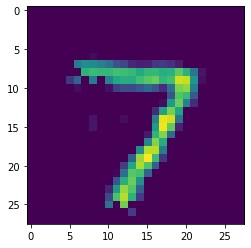

In [16]:
with nengo_dl.Simulator(auto_net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(output[p_c][0].reshape((28, 28)))
    plt.show()

More details on using `sim.fit` can be found in [the user
guide](https://www.nengo.ai/nengo-dl/simulator.html).

## NEF parameter optimization

NengoDL also provides access to a different optimization method, the Neural Engineering
Framework (NEF).  This uses linear least-squares optimization to solve for optimal
connection weights analytically, rather than using an iterative gradient-descent based
algorithm.  The advantage of the NEF is that it is very fast and general (for example,
it does not require the network to be differentiable).  The disadvantage is that it
optimizes each set of connection weights individually (i.e., it cannot jointly optimize
across multiple layers).

The NEF optimization is accessed by setting the `function` argument on a
`nengo.Connection`.  This specifies the function that we would like those connection
weights to approximate.  In addition, in previous examples you may have noticed that we
were forming Connections using `ensemble.neurons` (rather than `ensemble`).  Using
`ensemble.neurons` specifies that we want to form a direct connection between ensemble
neurons, without applying the NEF optimization.  So when we want to use the `function`
argument, the `Connection` source object should be an `ensemble`, not
`ensemble.neurons`.  For example, we could use the NEF to create a network to
approximate the function $sin(x^2)$:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|##############Constructing graph: build stage (22%)             | ETA: 0:00:00

|##############Constructing graph: build stage (55%)             | ETA: 0:00:00

| #                       Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|#######       Constructing graph: build stage (11%)             | ETA: 0:00:00

| #                           Simulating                              | 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|  #                          Simulating                              | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

|        #                    Simulating                              | 0:00:00

|         #                   Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

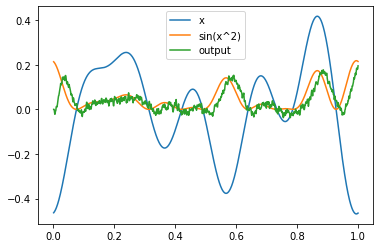

In [17]:
with nengo.Network(seed=0) as net:
    # input node outputting a random signal for x
    inpt = nengo.Node(nengo.processes.WhiteSignal(1, 5, rms=0.3))

    # first ensemble, will compute x^2
    ens0 = nengo.Ensemble(50, 1)

    # second ensemble, will compute sin(x^2)
    ens1 = nengo.Ensemble(50, 1)

    # output node
    outpt = nengo.Node(size_in=1)

    # connect input to first ensemble
    nengo.Connection(inpt, ens0)

    # connect first to second ensemble, solve for weights
    # to approximate the square function
    nengo.Connection(ens0, ens1, function=np.square)

    # connect second ensemble to output, solve for weights
    # to approximate the sin function
    nengo.Connection(ens1, outpt, function=np.sin)

    # add a probe on the input and output
    inpt_p = nengo.Probe(inpt)
    outpt_p = nengo.Probe(outpt, synapse=0.005)

with nengo_dl.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

The NEF optimization can be used in combination with the deep learning optimization
methods.  For example, we could optimize some parameters with the NEF and others with
`sim.fit` (see [this example](https://www.nengo.ai/nengo-dl/examples/from-nengo.html)).
Or we could initialize each set of connection weights individually with the NEF, and
then further refine them with end-to-end training via `sim.fit`.  As always, the overall
theme is that NengoDL allows us to use whichever method is most appropriate for a
particular goal.

See [this example](https://www.nengo.ai/nengo/examples/advanced/nef_summary.html) for a
deeper introduction to the principles of the NEF.

## Running on neuromorphic hardware

Neuromorphic hardware is specialized compute hardware designed to simulate neuromorphic
networks quickly/efficiently.  However, often it is difficult to program this custom
hardware, and it requires writing custom code for each neuromorphic platform.  One of
the primary design goals of Nengo is to alleviate these challenges, by providing a
single API that can be used to build networks across many different neuromorphic
platforms.

The idea is that the front-end network construction code is the same (`Networks`,
`Nodes`, `Ensembles`, `Connections`, and `Probes`), and then each platform has its own
`Simulator` class (the back-end) that compiles and executes that network definition for
some compute platform.  This provides a consistent interface so that we only need to
write code once and can then run that network on novel hardware platforms with no
additional effort.  For example, we could take the network from above and simulate it on
different hardware platforms:

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

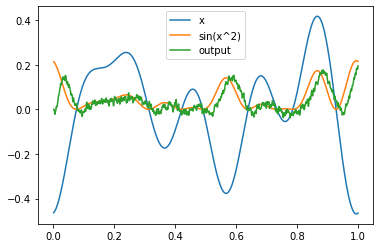

In [18]:
# run on a standard CPU
with nengo.Simulator(net, seed=0) as sim:
    sim.run_steps(1000)

# run on Loihi neuromorphic hardware
# (requires https://www.nengo.ai/nengo-loihi/)
# with nengo_loihi.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on SpiNNaker neuromorphic hardware
# (requires https://github.com/project-rig/nengo_spinnaker)
# with nengo_spinnaker.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

# run on any OpenCL-compatible hardware
# (requires https://github.com/nengo-labs/nengo-ocl)
# with nengo_ocl.Simulator(net, seed=0) as sim:
#     sim.run_steps(1000)

plt.figure()
plt.plot(sim.trange(), sim.data[inpt_p], label="x")
plt.plot(sim.trange(), np.sin(sim.data[inpt_p] ** 2), label="sin(x^2)")
plt.plot(sim.trange(), sim.data[outpt_p], label="output")
plt.legend()
plt.show()

We have commented out the different backends above because they require extra
installation steps, but if you are running this example yourself you can install any of
those backends (or more) and uncomment that code to see the same network running on that
new hardware platform.  Note that we can think of NengoDL as a TensorFlow back-end
(among other things); it takes a standard Nengo network, and simulates it using
TensorFlow.

We can take advantage of this cross-platform compatibility to effectively incorporate
NengoDL's deep learning functionality into any other Nengo back-end.  We build our
Network, optimize it in NengoDL, save the optimized model parameters back into the
Network definition, and then simulate that optimized Network in a different back-end.
See [this example in
nengo-loihi](https://www.nengo.ai/nengo-loihi/examples/mnist_convnet.html), where a
spiking network is optimized in NengoDL and then deployed on Loihi.

## Conclusion

In this tutorial we have demonstrated how to translate TensorFlow concepts into NengoDL,
including network construction, execution, and optimization.  We have also discussed how
to use TensorNodes to combine TensorFlow and Nengo code, and introduced some of the
unique features of Nengo (such as NEF optimization and neuromorphic cross-platform
execution).  However, there is much more functionality in NengoDL than we are able to
introduce here; check out the [user
guide](https://www.nengo.ai/nengo-dl/user-guide.html) or [other
examples](https://www.nengo.ai/nengo-dl/examples.html) for more information.  If you
would like more information on how NengoDL is implemented under the hood using
TensorFlow, check out the [white paper](https://arxiv.org/abs/1805.11144).